# Code for generating Fig 4.5 (Scaling of gate times)

In [1]:
# %% Import modules
import time
import matplotlib.pyplot as plt
import numpy as np
import scipy
import matplotlib.transforms as mtransforms

# Our own files
from simulator_program.custom_noise_models import (standard_times)
from simulator_program.data_analysis_tools import (fidelity_from_scratch,
                                                   perfect_stab_circuit,
                                                   scale_gate_times)


Adding custom device equivalences


/home/alexion/anaconda3/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


We start by defining some settings and functions used across all runs and configurations

In [2]:
# Noise parameters
T1 = 40e3
T2 = 60e3

# Number of runs
n_cycles = 15
n_shots = 1024*8*2

# Functions for curve fitting
def monoExp(t, T, c, A):
    return (A-c) * np.exp(-t/T) + c
def idealExp(t,T): # For the projected qubit we set A=1 and c=0.5
    return 0.5 * np.exp(-t/T) + 0.5

p0 = (T1, 0.4, 0.9)  # start with values near those we expect*

def get_circuit_time_formula(gate_times = {}):
    tot_gate_times= standard_times.get_gate_times(gate_times)
    return (8*tot_gate_times['h']+16*tot_gate_times['cz']+ 4*tot_gate_times['measure']+ \
            tot_gate_times['feedback'] + tot_gate_times['delay'])/1000

We also write a general function for running through all the iterations for
scaling a specific gate time.

The procedure is as follows:
- Determine the gate times for the current run
- Run simulations with these parameters
- Determine a curve fit for the results 
- Repeat from start with the next iteration

Note that, with these parameters, this is VERY computationally heavy. This can
be sped up by reducing the number of cycles and shots, but at the cost of accuracy.
Otherwise, the data from previous runs can simply be loaded further down.

In [3]:
def iterate_through_scaling(n_cycles, n_shots, resolution, scaling_span, 
                            scaled_gate_type, T1=40e3, T2=60e3, 
                            print_time=True, plot_intermediate_result=False):

    # Define additional variables
    fid_span = np.zeros((resolution, n_cycles+1)) # Fidelities at each cycle and setup
    P_L_span = np.zeros((resolution, n_cycles+1)) # P_L at each cycle and setup
    time_span = np.zeros((resolution, n_cycles+1)) # Time passed at each cycle and setup
    par_span = np.zeros((resolution, 3))
    par_L_span = np.zeros((resolution, 3))
    cov_span = np.zeros((resolution, 3,3))
    cov_L_span = np.zeros((resolution, 3,3))

    for i in range(resolution):

        if print_time:
            seconds = time.time()

        # Define the gate time we're scaling. Others are set to standard times
        if scaled_gate_type == 'single_qubit':
            gate_times = {'h': scaling_span[i]} # The only single-qubit gate used
        elif scaled_gate_type == 'two_qubit':
            gate_times = {'cz': scaling_span[i]}   # The only two-qubit gate used
        elif scaled_gate_type == 'measure':
            gate_times = {'measure': scaling_span[i]}
        elif scaled_gate_type == 'feedback':
            gate_times = {'feedback': scaling_span[i]}
        elif scaled_gate_type == 'delay':
            gate_times = {'delay': scaling_span[i]}
        elif scaled_gate_type == 'all': # Delay is NOT included in this
            gate_times = {
                'h': scaling_span[0][i], 
                'cz': scaling_span[1][i], 
                'measure': scaling_span[2][i],
                'feedback': scaling_span[3][i],
            }
        else:
            print('ERROR: Invalding scaled_gate_type, exiting')
            return

        # Calculate F_L and P_L (Computationally heavy step)
        fid_span[i], P_L_span[i], times = fidelity_from_scratch(
            n_cycles, n_shots, gate_times,
            T1=T1, T2=T2, encoding=False, transpile=False, project=True)

        # Convert time to list
        time_span[i] = np.array([times['dm_'+str(i)] for i in range(n_cycles+1)])

        # Find curve fit to F_L and F to determine T_L (And other parameters)
        pars, cov = scipy.optimize.curve_fit(
            monoExp, time_span[i][1:], (fid_span[i]*P_L_span[i])[1:], p0)
        pars_L, cov_L = scipy.optimize.curve_fit(
            idealExp, time_span[i][1:]-time_span[i][1], fid_span[i][1:], T1)

        # Store curve parameters
        par_span[i] = pars
        par_L_span[i] = pars_L
        cov_span[i] = cov
        cov_L_span[i] = cov_L

        if plot_intermediate_result:
            # Plot results of current iteration
            plt.plot(time_span[i]/1000, fid_span[i] *
                     P_L_span[i], 'o', label='F', color='C0')
            plt.plot(time_span[i]/1000, fid_span[i],
                     '^', label='F_L', color='C2')
            plt.plot(time_span[i]/1000, P_L_span[i],
                     's', label='P_L', color='C3')

            plt.plot(time_span[i]/1000, monoExp(time_span[i], *pars), 
                    '--', color='C0')
            plt.plot(time_span[i]/1000, idealExp(time_span[i]-time_span[i][1], *pars_L),
                    '--', color='C2')
            plt.plot(time_span[i]/1000, monoExp(time_span[i], *pars) /
                     idealExp(time_span[i]-time_span[i][1], *pars_L), '--', color='C3')
            plt.title(
                'Current iteration: ' + str(i+1) + ' out of ' + str(resolution) +
                ' \n-> F: T='+str(np.round(pars[0]/1000, 1)) + 
                ' c='+str(np.round(pars[1], 2)) + ' A='+str(np.round(pars[2], 2)) +
                '\n F_L: '+'T='+str(np.round(pars_L[0]/1000, 1)))
            plt.legend()
            plt.show()

        if print_time:
            print('This took ', int(time.time()-seconds), 'seconds')
            print('current_iteration: ', i)
    return fid_span, P_L_span, time_span, par_span, par_L_span, cov_span, cov_L_span

## Single qubit gates
We work through each gate type one by one, starting with the scaling of single
qubit gates.

Note that the scaling of single qubit gates is not included in the plot as their impact is insignificant. Also, the pre-generated data is done with very low accuracy and may not be reliable

In [4]:
# Gate times to test
resolution = 7
single_qubit_min = 0
single_qubit_max = 60
single_qubit_span = np.linspace(single_qubit_min, single_qubit_max, resolution)

In [ ]:
# Run simulation 
# WARNING: TAKES LONG TIME
# Consider loading the data further down instead
single_qubit_fid, single_qubit_P_L, single_qubit_time, single_qubit_par, single_qubit_par_L, single_qubit_cov, single_qubit_cov_L = \
    iterate_through_scaling(n_cycles, n_shots, resolution, single_qubit_span, 
                            scaled_gate_type='single_qubit', T1=40e3, T2=60e3, 
                            print_time=True, plot_intermediate_result=True)

In [7]:
# SAVE DATA
with open('data/scale_single_qubit_gate.npy', 'wb') as f:
    np.save(f, (single_qubit_span))
    np.save(f, (single_qubit_fid, single_qubit_P_L, single_qubit_time))
    np.save(f, (single_qubit_par, single_qubit_par_L))
    np.save(f, (single_qubit_cov, single_qubit_cov_L))

## Two-qubit gates
We simply repeat the procedure with the other gate time scalings

In [77]:
# Two qubit gate
resolution = 17
two_qubit_min = 0
two_qubit_max = 400
two_qubit_span = np.linspace(two_qubit_min, two_qubit_max, resolution)

array([ 0., 10., 20., 30., 40., 50., 60.])

In [64]:
# Run simulation 
# WARNING: TAKES LONG TIME
# Consider loading the data further down instead
two_qubit_fid, two_qubit_P_L, two_qubit_time, two_qubit_par, two_qubit_par_L, two_qubit_cov, two_qubit_cov_L = \
    iterate_through_scaling(n_cycles, n_shots, resolution, two_qubit_span, 
                            scaled_gate_type='two_qubit', T1=40e3, T2=60e3, 
                            print_time=True, plot_intermediate_result=True)

array([1])

In [31]:
# SAVE DATA
with open('data/scale_two_qubit_gate.npy', 'wb') as f:
    np.save(f, (two_qubit_span))
    np.save(f, (two_qubit_fid, two_qubit_P_L, two_qubit_time))
    np.save(f, (two_qubit_par, two_qubit_par_L))
    np.save(f, (two_qubit_cov, two_qubit_cov_L))

## Measure time
This is the time for any qubit measurement, and its default is 300ns

In [ ]:
# Measurement
resolution = 16
measure_min = 0
measure_max = 1500
measure_span = np.linspace(measure_min, measure_max, resolution)

In [ ]:
# Run simulation 
# WARNING: TAKES LONG TIME
# Consider loading the data further down instead
measure_fid, measure_P_L, measure_time, measure_par, measure_par_L, measure_cov, measure_cov_L = \
    iterate_through_scaling(n_cycles, n_shots, resolution, measure_span, 
                            scaled_gate_type='measure', T1=40e3, T2=60e3, 
                            print_time=True, plot_intermediate_result=True)

In [29]:
# SAVE DATA
with open('data/scale_measure.npy', 'wb') as f:
    np.save(f, (measure_span))
    np.save(f, (measure_fid, measure_P_L, measure_time))
    np.save(f, (measure_par, measure_par_L))
    np.save(f, (measure_cov, measure_cov_L))

## Feedback time
Here we scale the time for feedback. This corresponds to the classical processing of the syndrome, and its standard value is set to 350 ns

In [ ]:
# Feedback
resolution = 17
feedback_min = 0
feedback_max = 8000
feedback_span = np.linspace(feedback_min, feedback_max, resolution)

In [ ]:
# Run simulation 
# WARNING: TAKES LONG TIME
# Consider loading the data further down instead
feedback_fid, feedback_P_L, feedback_time, feedback_par, feedback_par_L, feedback_cov, feedback_cov_L = \
    iterate_through_scaling(n_cycles, n_shots, resolution, feedback_span, 
                            scaled_gate_type='feedback', T1=40e3, T2=60e3, 
                            print_time=True, plot_intermediate_result=True)

In [35]:
# SAVE DATA
with open('data/scale_feedback.npy', 'wb') as f:
    np.save(f, (feedback_span))
    np.save(f, (feedback_fid, feedback_P_L, feedback_time))
    np.save(f, (feedback_par, feedback_par_L))
    np.save(f, (feedback_cov, feedback_cov_L))

## Delay time
Here we introduce and scale an idle time in between stabilizer cycles. Default is set to 0

In [9]:
# Delay
resolution = 17
delay_min = 0
delay_max = 8000
delay_span = np.linspace(delay_min, delay_max, resolution)

In [ ]:
# Run simulation 
# WARNING: TAKES LONG TIME
# Consider loading the data further down instead
delay_fid, delay_P_L, delay_time, delay_par, delay_par_L, delay_cov, delay_cov_L = \
    iterate_through_scaling(n_cycles, n_shots, resolution, delay_span, 
                            scaled_gate_type='delay', T1=40e3, T2=60e3, 
                            print_time=True, plot_intermediate_result=True)

In [39]:
# SAVE DATA
with open('data/scale_delay.npy', 'wb') as f:
    np.save(f, (delay_span))
    np.save(f, (delay_fid, delay_P_L, delay_time))
    np.save(f, (delay_par, delay_par_L))
    np.save(f, (delay_cov, delay_cov_L))

## Scaling all gate times
Finally, we scale all gate times simultaneously. This is done proportionally to their default value. Note that delay time will always be set to 0

In [14]:
# All times (except delay)
scalings = np.array([0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0])
resolution = len(scalings)
all_times = scale_gate_times(gate_times=standard_times, scalings=scalings)
single_qubit_span_all = np.zeros(resolution)
two_qubit_span_all = np.zeros(resolution)
measure_span_all = np.zeros(resolution)
feedback_span_all = np.zeros(resolution)
for i in range(resolution):
    single_qubit_span_all[i] = all_times['single_qubit_gate'][i]
    two_qubit_span_all[i] = all_times['two_qubit_gate'][i]
    measure_span_all[i] = all_times['measure'][i]
    feedback_span_all[i] = all_times['feedback'][i]
all_span = [single_qubit_span_all, two_qubit_span_all, measure_span_all, feedback_span_all]

In [ ]:
# Run simulation 
# WARNING: TAKES LONG TIME
# Consider loading the data further down instead
all_fid, all_P_L, all_time, all_par, all_par_L, all_cov, all_cov_L = \
    iterate_through_scaling(n_cycles, n_shots, resolution, all_span, 
                            scaled_gate_type='all', T1=40e3, T2=60e3, 
                            print_time=True, plot_intermediate_result=True)

In [49]:
# SAVE DATA
with open('data/scale_all.npy', 'wb') as f:
    np.save(f, (all_span))
    np.save(f, (all_fid, all_P_L, all_time))
    np.save(f, (all_par, all_par_L))
    np.save(f, (all_cov, all_cov_L))

# Loading data
Here we can load all the data instead of running simulations

In [ ]:
# LOAD SINGLE QUBIT DATA (Not used in plots)
with open('data/scale_single_qubit_gate.npy', 'rb') as f:
    singlespan = np.load(f)
    singlefid, singlepl, singletime = np.load(f)
    singlepar, singleparl = np.load(f)
    singlecov, singlecovl = np.load(f)

In [ ]:
# LOAD TWO-QUBIT GATE DATA
with open('data/scale_two_qubit_gate.npy', 'rb') as f:
    two_qubit_span = np.load(f)
    two_qubit_fid, two_qubit_P_L, two_qubit_time = np.load(f)
    two_qubit_par, two_qubit_par_L = np.load(f)
    two_qubit_cov, two_qubit_cov_L = np.load(f)

In [ ]:
# LOAD MEASURE DATA
with open('data/scale_measure.npy', 'rb') as f:
    measure_span = np.load(f)
    measure_fid, measure_P_L, measure_time = np.load(f)
    measure_par, measure_par_L = np.load(f)
    measure_cov, measure_cov_L = np.load(f)

In [ ]:
# LOAD FEEDBACK DATA
with open('data/scale_feedback.npy', 'rb') as f:
    feedback_span = np.load(f)
    feedback_fid, feedback_P_L, feedback_time = np.load(f)
    feedback_par, feedback_par_L = np.load(f)
    feedback_cov, feedback_cov_L = np.load(f)

In [ ]:
# LOAD DELAY DATA
with open('data/scale_delay.npy', 'rb') as f:
    delay_span = np.load(f)
    delay_fid, delay_P_L, delay_time = np.load(f)
    delay_par, delay_par_L = np.load(f)
    delay_cov, delay_cov_L = np.load(f)

In [9]:
# LOAD ALL GATE TIME SCALING DATA
with open('data/scale_all.npy', 'rb') as f:
    all_span = np.load(f)
    all_fid, all_P_L, all_time = np.load(f)
    all_par, all_par_L = np.load(f)
    all_cov, all_cov_L = np.load(f)

# Plotting

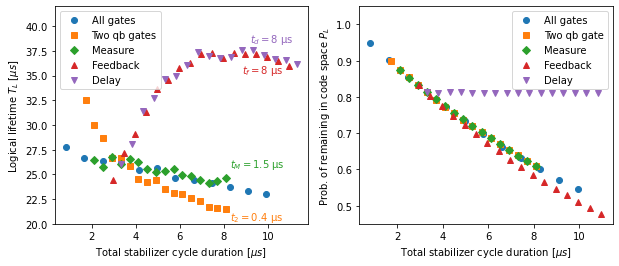

In [19]:
#%% Plots

fig, ax = plt.subplots(1,2, figsize=(10, 4))
def_colors = plt.get_cmap("tab10")
all_times = scale_gate_times(gate_times=standard_times, scalings=scalings)

# Calculate cycle times
times_all = []
for i in range(len(all_span[0])):
    single_qubit = all_times['single_qubit_gate'][i]
    two_qubit = all_times['two_qubit_gate'][i]
    measure = all_times['measure'][i]
    feedback = all_times['feedback'][i]
    times_all.append(get_circuit_time_formula({'h': single_qubit,
                                               'cz': two_qubit,
                                               'measure': measure,
                                               'feedback': feedback}))
times_two_qubit = []
for time in two_qubit_span:
    times_two_qubit.append(get_circuit_time_formula({'cz': time}))
times_measure = []
for time in measure_span:
    times_measure.append(get_circuit_time_formula({'measure': time}))
times_feedback = []
for time in feedback_span:
    times_feedback.append(get_circuit_time_formula({'feedback': time}))
times_delay = []
for time in delay_span:
    times_delay.append(get_circuit_time_formula({'delay': time}))

# Subplot 1: T_L
ax[0].plot(times_all, all_par_L[:,0]*1e-3,
    linestyle='None', marker='o', label='All gates')
ax[0].plot(times_two_qubit, two_qubit_par_L[:,0]*1e-3,
    linestyle='None', marker='s', label='Two qb gates')
ax[0].plot(times_measure, measure_par_L[:,0]*1e-3,
    linestyle='None', marker='D', label='Measure')
ax[0].plot(times_feedback, feedback_par_L[:,0]*1e-3, 
    linestyle='None', marker='^', label='Feedback')
ax[0].plot(times_delay, delay_par_L[:,0]*1e-3,
    linestyle='None', marker='v', label='Delay')

trans_offset_up = mtransforms.offset_copy(ax[0].transData, fig=fig,
                                       x=.05, y=-0.15, units='inches')
trans_offset_down = mtransforms.offset_copy(ax[0].transData, fig=fig,
                                       x=.05, y=0.15, units='inches')
trans_offset_left = mtransforms.offset_copy(ax[0].transData, fig=fig,
                                       x=-.65, y=-0.1, units='inches')
trans_offset_delay = mtransforms.offset_copy(ax[0].transData, fig=fig,
                                       x=-.65, y=0.3, units='inches')

ax[0].text(times_two_qubit[-1], two_qubit_par_L[-1,0]*1e-3, 
           rf'$t_2 ={two_qubit_span[-1]*1e-3:.1f}$ μs',
           color='C1', transform=trans_offset_up)
ax[0].text(times_measure[-1], measure_par_L[-1,0]*1e-3,
           rf'$t_M ={measure_span[-1]*1e-3:.1f}$ μs',
           color='C2', transform=trans_offset_down)
ax[0].text(times_feedback[-1], feedback_par_L[-1,0]*1e-3,
           rf'$t_f ={feedback_span[-1]*1e-3:.0f}$ μs',
           color='C3', transform=trans_offset_left)
ax[0].text(times_delay[-1], delay_par_L[-1,0]*1e-3,
           rf'$t_d ={delay_span[-1]*1e-3:.0f}$ μs',
           color='C4', transform=trans_offset_delay)

#ax.set_title(r'Logical Lifetime over scaling gate times')
ax[0].set_xlabel(r'Total stabilizer cycle duration $[\mu s]$')
ax[0].set_ylabel(r'Logical lifetime $T_L$ $[\mu s]$')
ax[0].set(ylim=(20,42))

ax[0].legend(loc='upper left')

# Subplot 2: P_L
P_L_all = np.sum(all_P_L[:,1:],1)/n_cycles
ax[1].plot(times_all, P_L_all, 'o', label='All gates')
P_L_two_qubit = np.sum(two_qubit_P_L[:,1:],1)/n_cycles
ax[1].plot(times_two_qubit, P_L_two_qubit, 's', label='Two qb gate')
P_L_measure = np.sum(measure_P_L[:,1:],1)/n_cycles
ax[1].plot(times_measure, P_L_measure, 'D', label='Measure')
P_L_feedback = np.sum(feedback_P_L[:,1:],1)/n_cycles
ax[1].plot(times_feedback, P_L_feedback, '^', label='Feedback')
P_L_delay = np.sum(delay_P_L[:,1:],1)/n_cycles
ax[1].plot(times_delay[:16], P_L_delay[:16], 'v', label='Delay')


colors_def = plt.get_cmap("tab10")




ax[1].set_xlabel(r'Total stabilizer cycle duration $[\mu s]$')
ax[1].set_ylabel(r'Prob. of remaining in code space $P_L$')

ax[1].set(ylim=(0.45,1.05))
ax[1].legend()